In [1]:
# Car Price Prediction with PySpark
# data-info: Used cars in United States for sale
# data-source: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

import json

import matplotlib.pyplot as plt
import seaborn as sns

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import types
from pyspark.sql import functions as F

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark=SparkSession.builder.master("local[*]").appName('Final Pre').getOrCreate()
sc=spark.sparkContext

22/12/06 12:33:33 WARN Utils: Your hostname, MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.232.189.235 instead (on interface en0)
22/12/06 12:33:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/12/06 12:33:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
df_cars = spark.read.options(header=True, inferSchema=True, delimiter=',', multiLine=True).csv('vehicles.csv')

In [3]:
df_cars.printSchema()

root
 |-- id: long (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (null

In [4]:
# Data Cleaning
# these columns are useless to us, drop them

drop_cols = ['url', 'region_url', 'image_url', 'county','description']

df_cars = df_cars.drop(*drop_cols)

In [5]:
# both null values and null indicators(other) exist, set the indicator to null (to prevent confusion)

df_cars = df_cars.replace('other', None, subset=['cylinders'])

In [6]:
# both null values and null indicators(missing) exist, set the indicator to null (to prevent confusion)

df_cars = df_cars.replace('missing', None, subset=['title_status'])

In [7]:
# Latitude should be between (-90, 90), otherwise set null

df_cars = df_cars.withColumn('lat', F.when(F.col('lat').rlike('^-?\d+\.?\d+$'), F.col('lat')))
df_cars = df_cars.withColumn('lat', F.col('lat').cast(types.FloatType()))
df_cars = df_cars.withColumn('lat', F.when((-90 <= F.col('lat')) & (F.col('lat') <= 90), F.col('lat')))

In [8]:
# Longitude should be between (-180, 180), otherwise set null

df_cars = df_cars.withColumn('long', F.when(F.col('long').rlike('^-?\d+\.?\d+$'), F.col('long')))
df_cars = df_cars.withColumn('long', F.col('long').cast(types.FloatType()))
df_cars = df_cars.withColumn('long', F.when((-180 <= F.col('long')) & (F.col('long') <= 180), F.col('long')))

In [9]:
# Posting date should be in format yyyy-MM-dd HH:mm:ss.SSSS

df_cars = df_cars.withColumn('posting_date', F.when(F.col('posting_date').rlike('^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}-\d{4}$'), F.col('posting_date')))
df_cars = df_cars.withColumn('posting_date', F.col('posting_date').cast(types.TimestampType()))

In [10]:
df_cars.select('price', 'year', 'odometer', 'lat', 'long').summary().show()

+-------+-------------------+------------------+------------------+-----------------+------------------+
|summary|              price|              year|          odometer|              lat|              long|
+-------+-------------------+------------------+------------------+-----------------+------------------+
|  count|             426582|            425377|            422182|           365481|            367830|
|   mean|  75240.00097753773|2011.2356544900172|  98019.2444514451|38.27485954294108|-92.92308876290198|
| stddev|1.218653645968038E7|   9.4529441236719|213407.41232087038|5.757416442913367| 20.91019012781645|
|    min|                  0|              1900|                 0|       -84.122246|        -159.82773|
|    25%|               5900|              2008|             37675|          34.4329|           -106.62|
|    50%|              13950|              2013|             85519|          39.0278|        -87.322266|
|    75%|              26455|              2017|       

In [11]:
# Top 5   state of sale
from pyspark.sql import functions as F
df_region = df_cars.groupBy('state').agg(F.count('state').alias('count_state')).sort('count_state', ascending=False).show(5)

+-----+-----------+
|state|count_state|
+-----+-----------+
|   ca|      44223|
|   fl|      25601|
|   tx|      20259|
|   ny|      17731|
|   oh|      16060|
+-----+-----------+
only showing top 5 rows



In [12]:
#Time-series
df_year_series =  df_cars.filter(df_cars.year.between(2000,2021)).groupBy('year').agg(F.count('id').alias('count_year_series')).sort('year', ascending=True).show(23)

+----+-----------------+
|year|count_year_series|
+----+-----------------+
|2000|             3570|
|2001|             4441|
|2002|             5582|
|2003|             7148|
|2004|             8961|
|2005|            10607|
|2006|            12753|
|2007|            14862|
|2008|            17141|
|2009|            12181|
|2010|            15817|
|2011|            20335|
|2012|            23872|
|2013|            30769|
|2014|            30250|
|2015|            31517|
|2016|            30411|
|2017|            36401|
|2018|            36354|
|2019|            25363|
|2020|            19289|
|2021|             2394|
+----+-----------------+



In [13]:
#Top 5 year of sale
df_year = df_cars.groupBy('year').agg(F.count('id').alias('count_year')).sort('count_year', ascending=False).show(5)

+----+----------+
|year|count_year|
+----+----------+
|2017|     36401|
|2018|     36354|
|2015|     31517|
|2013|     30769|
|2016|     30411|
+----+----------+
only showing top 5 rows



In [14]:
# Top 5 brand of sale and their avg price
df_brand = df_cars.filter(df_cars.price > 0).groupBy('manufacturer').agg(F.count('manufacturer').alias('count_brand'), F.mean('price')).sort('count_brand', ascending=False).show(5)

+------------+-----------+------------------+
|manufacturer|count_brand|        avg(price)|
+------------+-----------+------------------+
|        ford|      64812|39864.205178053446|
|   chevrolet|      50606|125853.26328893808|
|      toyota|      31581|253727.79300845446|
|       honda|      19857|11510.740041295261|
|        jeep|      17451|164208.02011346054|
+------------+-----------+------------------+
only showing top 5 rows



In [15]:
# Top 5 brand of sale and their avg price in st. Louis
df_brand_st = df_cars.filter((df_cars.region=='st louis, MO')&(df_cars.price > 0)).groupBy('manufacturer').agg(F.count('manufacturer').alias('count_brand'), F.mean("price")).sort('count_brand', ascending=False).show(5)

+------------+-----------+------------------+
|manufacturer|count_brand|        avg(price)|
+------------+-----------+------------------+
|        ford|        519|19408.915221579962|
|   chevrolet|        473| 21270.79492600423|
|      toyota|        153|14944.725490196079|
|         ram|        148|28041.547297297297|
|         gmc|        147|24645.993197278913|
+------------+-----------+------------------+
only showing top 5 rows



In [16]:
#The median of price of different fuel-types of cars
df_fuel_price = df_cars.filter((df_cars.price > 0)&(df_cars.fuel != "null")).groupBy('fuel').agg(F.percentile_approx("price", 0.5).alias('median_fuel_price')).sort('median_fuel_price', ascending=False).show()

+--------+-----------------+
|    fuel|median_fuel_price|
+--------+-----------------+
|  diesel|            31990|
|   other|            27590|
|electric|            24990|
|     gas|            13500|
|  hybrid|            12950|
+--------+-----------------+



In [17]:
#Which states love electric car most
df_electric_state = df_cars.filter(df_cars.fuel=='electric').groupBy('state').agg(F.count('id').alias('count_id')).sort('count_id', ascending=False).show(5)

+-----+--------+
|state|count_id|
+-----+--------+
|   ca|     319|
|   fl|     115|
|   ny|      73|
|   tx|      69|
|   oh|      57|
+-----+--------+
only showing top 5 rows



In [20]:
# Price Indicator
df_cars = df_cars.withColumn('price', F.log10(F.col('price') + 1))
df_cars = df_cars.withColumn('odometer', F.log10(F.col('odometer') + 1))

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
df_cars.registerTempTable('car_table')

df_result = spark.sql('SELECT condition, odometer, price FROM car_table')
df_result = df_result.toPandas()


22/12/06 12:38:05 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


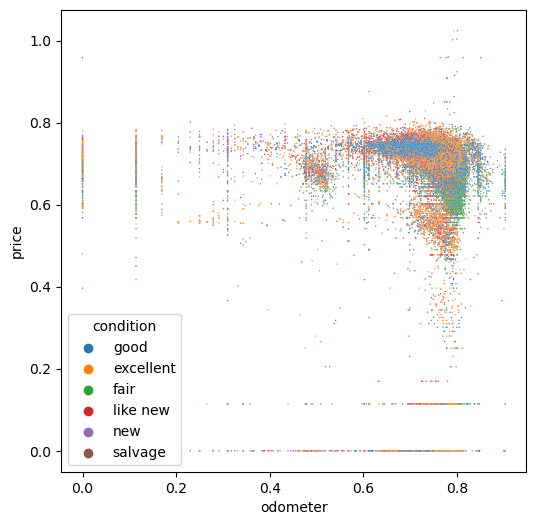

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot = sns.scatterplot(data=df_result, x='odometer', y='price', hue='condition', ax=ax, s=1)

plt.show()

In [22]:
df_result = spark.sql('SELECT year, fuel, price FROM car_table')
df_result = df_result.toPandas()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


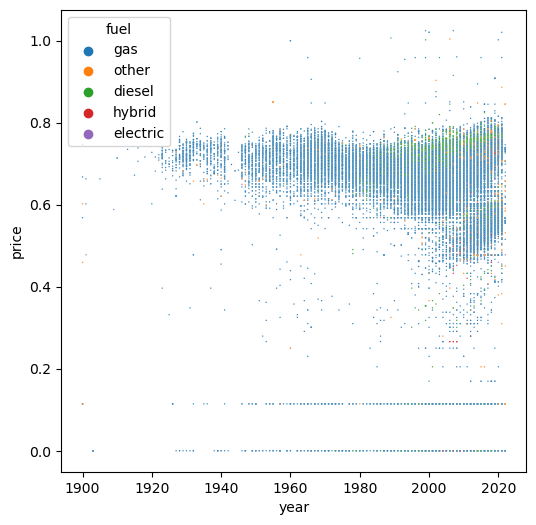

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot = sns.scatterplot(data=df_result, x='year', y='price', hue='fuel', ax=ax, s=1)

plt.show()